In [70]:
import os

from typing import List, Optional, Dict
from pydantic.dataclasses import dataclass
from pydantic import BaseModel
import textwrap

from PIL import Image

import numpy as np
import glob

from myutil import *

In [47]:
adet = read_binary("unpacked/ADET.GP")
len(adet)

228443

In [48]:
@dataclass
class GpVocabulary:
    voc_offset: int
    voc_length: int
    data: bytes

    def __repr__(self) -> str:
        return f"GpVocabulary(voc_offset = {self.voc_offset}, voc_length = {self.voc_length})"

In [49]:
class GpHeader(BaseModel):
    next_pict: int
    dx: int
    dy: int
    lx: int
    ly: int
    pack: int  # actually pointer, but 0xFFFFFFFF when not loaded
    options: int
    cdata: int
    offset_data: bytes
    n_lines: int
    voc: GpVocabulary
    packed_data: Optional[bytes]
    next_pict_header: Optional['GpHeader']

    @property
    def opt(self) -> int:
        return self.options & 63

    @property
    def unpack_len(self) -> int:
        r = self.cdata >> 14

        opt = self.opt

        if opt == 43: r += 262144
        if opt == 44: r += 262144 * 2

        return r

    @property
    def cdoffs(self) -> int:
        r = self.cdata & 16383

        if (self.options & 64) != 0: r += 16384
        if (self.options & 128) != 0: r += 32768

        return r

    @property
    def opt_descr(self) -> str:
        opt = self.opt
        if opt == 0: return 'standard packing'
        if opt == 1: return 'National mask'
        if opt == 2: return 'transparent 1/4'
        if opt == 3: return 'transparent 2/4'
        if opt == 4: return 'transparent 3/4'
        if opt == 5: return 'Shadow'
        if opt == 6: return 'AlphaRY'
        if opt == 7: return 'AlphaWB'
        if opt == 38: return 'wtf 38'
        if opt == 39: return 'wtf 39'
        if opt == 41: return 'wtf 41'
        if opt in range(42, 45): return f'wtf {opt}'
        return f'unknown {opt}'

    @property
    def headers_list(self) -> List['GpHeader']:
        if self.next_pict_header is None:
            return [self]
        return [self] + self.next_pict_header.headers_list

    @property
    def get_lx(self):
        return max(h.dx + h.lx for h in self.headers_list)

    @property
    def get_ly(self):
        return max(h.dy + h.ly for h in self.headers_list)

    @property
    def get_dx(self):
        return min(h.dx for h in self.headers_list)

    @property
    def get_dy(self):
        return min(h.dy for h in self.headers_list)

    def try_unpack_data(self) -> Optional[bytes]:
        if self.opt == 0:
            return std_unpack(self.packed_data, self.unpack_len, self.voc.data)

        if self.opt == 38:
            return gray_unpack(self.packed_data, self.unpack_len)

        print(f'unsupported format: {self.opt}')

    def get_repr(self, field_names) -> str:
        fields = ', '.join(f"{name} = {self.__getattribute__(name)}" for name in field_names)
        return f"GpHeader({fields})"

    def __repr__(self) -> str:
        headers = self.headers_list
        fields = ['next_pict', 'dx', 'dy', 'lx', 'ly', 'options', 'opt', 'opt_descr', 'unpack_len', 'cdoffs', 'n_lines']
        return '[' + ',\n'.join(h.get_repr(fields) for h in headers) + ']'

    @staticmethod
    def get_size() -> int:
        # return 4 + 2 + 2 + 2 + 2 + 4 + 1 + 4 + 2
        return 23

    @staticmethod
    def parse(original_data: bytes, offset: int, *, parent_offset: Optional[int] = None,
              voc: GpVocabulary) -> 'GpHeader':
        data = original_data[offset:]

        r = GpHeader(
            next_pict=extract_int(data, 0, signed=True, size=4),
            dx=extract_int(data, 4, signed=True, size=2),
            dy=extract_int(data, 6, signed=True, size=2),
            lx=extract_int(data, 8, signed=True, size=2),
            ly=extract_int(data, 10, signed=True, size=2),
            pack=extract_int(data, 12, signed=False, size=4),
            options=extract_int(data, 16, signed=False, size=1),
            cdata=extract_int(data, 17, signed=False, size=4),
            n_lines=extract_int(data, 21, signed=True, size=2),
            voc=voc,
            offset_data=data[GpHeader.get_size():],
            packed_data=None,
            next_pict_header=None,
        )

        assert r.pack == 0xFF_FF_FF_FF
        r = r.copy(update={
            'packed_data': data[r.cdoffs:],
            'offset_data': r.offset_data[:r.cdoffs - 23],
        })

        if r.next_pict != -1:
            parent_offset = parent_offset or offset
            r = r.copy(
                update={'next_pict_header': GpHeader.parse(original_data, parent_offset + r.next_pict,
                                                           parent_offset=parent_offset, voc=voc)})

        return r


@dataclass
class GpGlobalHeader:
    signature: bytes
    n_pictures: int
    reserved: bytes
    voc: GpVocabulary
    headers_offsets: List[int]
    headers: List[GpHeader]

    @staticmethod
    def parse(data: bytes) -> 'GpGlobalHeader':
        assert extract_int(data, offset=0) == 0x4B_41_50_47

        n_pictures = extract_int(data, offset=4, signed=True, size=2)
        headers_offsets = [extract_int(data, offset=14 + i * 4, signed=False, size=4) for i in range(n_pictures)]

        voc_offset = extract_int(data, offset=8, signed=True, size=4)
        voc_length = extract_int(data, offset=12, signed=True, size=2)
        voc = GpVocabulary(
            voc_offset=voc_offset,
            voc_length=voc_length,
            data=data[voc_offset: voc_offset + voc_length]
        )

        return GpGlobalHeader(
            signature=data[0:4],
            n_pictures=n_pictures,
            reserved=data[6:8],
            voc=voc,
            headers_offsets=headers_offsets,
            headers=[GpHeader.parse(data, offset=i, voc=voc) for i in headers_offsets],
        )

    def __str__(self) -> str:
        return repr(self)

    def __repr__(self) -> str:
        headers = ',\n'.join(repr(h) for h in self.headers)

        return f"""GpGlobalHeader(
    signaure = {self.signature}
    n_pictures = {self.n_pictures}
    voc = {self.voc}
    headers_offsets = {self.headers_offsets}
    headers = \n{headers}"""

    @property
    def headers_flat(self) -> List[GpHeader]:
        result = []
        for hh in self.headers:
            result += hh.headers_list
        return result

In [50]:
sunduk10 = GpGlobalHeader.parse(read_binary("unpacked/SUNDUK1O.GP"))
sunduk1z = GpGlobalHeader.parse(read_binary("unpacked/SUNDUK1Z.GP"))
sunduk20 = GpGlobalHeader.parse(read_binary("unpacked/SUNDUK2O.GP"))
sunduk2z = GpGlobalHeader.parse(read_binary("unpacked/SUNDUK2Z.GP"))

In [51]:
sunduk10

GpGlobalHeader(
    signaure = b'GPAK'
    n_pictures = 2
    voc = GpVocabulary(voc_offset = 22, voc_length = 686)
    headers_offsets = [708, 2320]
    headers = 
[GpHeader(next_pict = 118, dx = 192, dy = 262, lx = 87, ly = 25, options = 38, opt = 38, opt_descr = wtf 38, unpack_len = 88, cdoffs = 96, n_lines = 25),
GpHeader(next_pict = 637, dx = 195, dy = 261, lx = 81, ly = 28, options = 0, opt = 0, opt_descr = standard packing, unpack_len = 791, cdoffs = 205, n_lines = 28),
GpHeader(next_pict = 959, dx = 194, dy = 261, lx = 85, ly = 29, options = 2, opt = 2, opt_descr = transparent 1/4, unpack_len = 108, cdoffs = 214, n_lines = 29),
GpHeader(next_pict = 1255, dx = 195, dy = 261, lx = 82, ly = 29, options = 3, opt = 3, opt_descr = transparent 2/4, unpack_len = 102, cdoffs = 194, n_lines = 29),
GpHeader(next_pict = -1, dx = 195, dy = 262, lx = 82, ly = 28, options = 4, opt = 4, opt_descr = transparent 3/4, unpack_len = 130, cdoffs = 227, n_lines = 28)],
[GpHeader(next_pict = 182, dx =

In [52]:
def gp_show_masked_pict(x: int, y: int, pic: GpHeader, cdata: bytes, screen: Screen):
    x += pic.dx
    y += pic.dy

    n_lines = pic.n_lines
    ofst = DataPtr(pic.offset_data, 0)

    # no clipping case
    assert x >= screen.x, f'Should be {x} >= {screen.x}'
    assert y >= screen.y, f'Should be {y} >= {screen.y}'
    assert x + pic.lx - 1 <= screen.x1, f'Should be {x + pic.lx - 1} <= {screen.x1}'
    assert y + n_lines - 1 <= screen.y1, f'Should be {y + n_lines - 1} <= {screen.y1}'

    cdpos = DataPtr(cdata, 0, allow_read_overflow=False)
    scr_offset: DataPtr = DataPtr(screen.data, x + y * screen.width)

    line_start: DataPtr = scr_offset.copy()
    line_start.advance(-screen.width)

    for line in range(n_lines):
        al = ofst.consume_one()
        line_start.advance(screen.width)
        edi = line_start.copy()

        if al == 0: continue

        if (al & 128) != 0:
            # DRAW_COMPLEX_LINE

            space_mask = 0
            pix_mask = 0
            if (al & 64) != 0: space_mask = 16
            if (al & 32) != 0: pix_mask = 16

            al = al & 31
            if al == 0:
                continue

            for _ in range(al):
                al = ofst.consume_one()
                cl = (al >> 4) | pix_mask
                al = (al & 0xF) | space_mask
                edi.advance(al)
                line = cdpos.consume_many(cl)
                edi.push_many(line)
            continue

        # START_SIMPLE_SEGMENT
        for _ in range(al):
            al = ofst.consume_one()
            edi.advance(al)
            cl = ofst.consume_one()
            line = cdpos.consume_many(cl)
            edi.push_many(line)

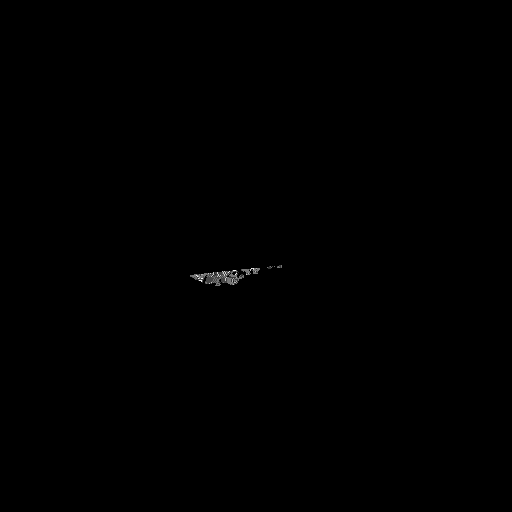

In [53]:


h1 = sunduk20.headers[0].headers_list[1]

screen = Screen(512, 512)
gp_show_masked_pict(0, 0, h1, h1.try_unpack_data(), screen)
screen.as_pic()

In [54]:
print_bytes(h1.try_unpack_data())

0:  	38_39_77_38_77_46_73_46_75_3a_39_78_76_36_36_38
16:  	75_76_77_77_3b_69_f4_cb_f1_75_78_af_79_78_78_36
32:  	36_38_59_77_77_78_78_76_69_74_45_cb_44_cb_76_78
48:  	36_7a_78_77_45_f3_f4_f4_57_46_73_77_78_77_75_79
64:  	78_cb_42_73_77_79_78_78_78_cb_44_cb_45_73_45_3d
80:  	ee_3e_46_73_61_59_2b_73_45_72_73_77_7a_7a_76_75
96:  	36_af_38_77_cb_20_42_43_db_43_43_44_45_63_cb_43
112:  	cb_45_72_ee_3e_46_73_61_59_2b_77_7a_7a_78_76_78
128:  	79_36_3a_77_76_74_45_cb_44_cb_45_73_cb_20_42_43
144:  	db_43_43_44_45_63_cb_43_cb_45_72_4e_73_74_2b_f1
160:  	2c_75_36_af_38_77_73_77_78_7a_78_76_78_79_36_36
176:  	7a_36_af_af_78_78_76_73_72_73_46_46_46_45_cb_42
192:  	20_42_43_db_43_43_44_45_63_cb_43_cb_45_72_73_77
208:  	78_f4_57_46_36_38_cb_75_78_76_73_66_73_77_78_7a
224:  	f5_ad_77_7a_36_7a_7a_78_76_77_46_73_46_73_45_cb
240:  	21_43_44_45_63_cb_43_cb_45_72_44_cb_45_73_45_77
256:  	77_78_78_78_76_76_74_77_36_3a_76_61_62_73_76_77
272:  	77_3b_f5_ad_77_7a_78_79_52_77_46_73_46_73_45_cb
288:  	21_60_45_74

In [55]:
print_bytes(h1.offset_data)

0:  	02_59_02_00_01_05_4f_02_01_01_01_01_02_04_00_01
16:  	03_4d_05_05_04_00_01_02_3d_09_08_03_02_33_0b_01
32:  	07_04_2a_05_04_08_01_01_01_07_04_20_10_05_01_01
48:  	05_03_05_05_17_14_03_01_01_01_07_04_03_05_05_0e
64:  	1a_01_01_03_03_08_05_02_05_05_04_23_01_03_02_03
80:  	03_02_03_04_04_00_10_01_15_01_08_03_04_04_00_0f
96:  	01_15_02_08_02_05_03_02_0d_02_1f_01_05_02_04_0a
112:  	02_24_03_05_09_02_0e_01_12_03_08_05_03_0d_02_12
128:  	03_0b_02_02_0f_01_11_03_0c_01_02_10_01_10_83_7f
144:  	44_98_02_1a_05_09_05_c1_59_05_

In [56]:
sunduk10

GpGlobalHeader(
    signaure = b'GPAK'
    n_pictures = 2
    voc = GpVocabulary(voc_offset = 22, voc_length = 686)
    headers_offsets = [708, 2320]
    headers = 
[GpHeader(next_pict = 118, dx = 192, dy = 262, lx = 87, ly = 25, options = 38, opt = 38, opt_descr = wtf 38, unpack_len = 88, cdoffs = 96, n_lines = 25),
GpHeader(next_pict = 637, dx = 195, dy = 261, lx = 81, ly = 28, options = 0, opt = 0, opt_descr = standard packing, unpack_len = 791, cdoffs = 205, n_lines = 28),
GpHeader(next_pict = 959, dx = 194, dy = 261, lx = 85, ly = 29, options = 2, opt = 2, opt_descr = transparent 1/4, unpack_len = 108, cdoffs = 214, n_lines = 29),
GpHeader(next_pict = 1255, dx = 195, dy = 261, lx = 82, ly = 29, options = 3, opt = 3, opt_descr = transparent 2/4, unpack_len = 102, cdoffs = 194, n_lines = 29),
GpHeader(next_pict = -1, dx = 195, dy = 262, lx = 82, ly = 28, options = 4, opt = 4, opt_descr = transparent 3/4, unpack_len = 130, cdoffs = 227, n_lines = 28)],
[GpHeader(next_pict = 182, dx =

In [72]:
def pic_of_all(header: GpGlobalHeader, palette: Optional[Palette] = None) -> Image.Image:
    screen = Screen(768, 768)
    for h in header.headers_flat:
        if h.opt == 0:
            gp_show_masked_pict(0, 0, h, h.try_unpack_data(), screen)

    return screen.as_interesting_pic(palette)


def pics_of_all(header: GpGlobalHeader, palette: Optional[Palette] = None) -> List[Image.Image]:
    result = []

    for h in header.headers_flat:
        screen = Screen(768, 768)
        if h.opt == 0:
            gp_show_masked_pict(0, 0, h, h.try_unpack_data(), screen)

        result.append(screen.as_interesting_pic(palette))

    return result

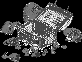

In [58]:
pic_of_all(sunduk10)

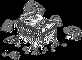

In [59]:
pic_of_all(sunduk1z)

In [60]:
pic_of_all(sunduk20)

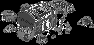

In [61]:
pic_of_all(sunduk2z)

In [62]:
all_palettes = Palette.load_all('unpacked')

all_palettes

{'unpacked/003X.PAL': <myutil.palette.Palette at 0x7f11a16c5810>,
 'unpacked/PALW.PAL': <myutil.palette.Palette at 0x7f11a16c6260>,
 'unpacked/DMW.PAL': <myutil.palette.Palette at 0x7f11a16c7610>,
 'unpacked/004W.PAL': <myutil.palette.Palette at 0x7f11a16c7370>,
 'unpacked/2W.PAL': <myutil.palette.Palette at 0x7f11a16c64a0>,
 'unpacked/TMP.PAL': <myutil.palette.Palette at 0x7f11a16c6440>,
 'unpacked/GRASS.PAL': <myutil.palette.Palette at 0x7f11a16c5840>,
 'unpacked/003.PAL': <myutil.palette.Palette at 0x7f11a167ed10>,
 'unpacked/003W.PAL': <myutil.palette.Palette at 0x7f11a167c190>,
 'unpacked/1W.PAL': <myutil.palette.Palette at 0x7f11a167dcf0>,
 'unpacked/TMPD.PAL': <myutil.palette.Palette at 0x7f11a167ca30>,
 'unpacked/DARKW.PAL': <myutil.palette.Palette at 0x7f11a167dcc0>,
 'unpacked/AGEW_1.PAL': <myutil.palette.Palette at 0x7f11a167d3c0>,
 'unpacked/004.PAL': <myutil.palette.Palette at 0x7f11a167e3b0>,
 'unpacked/DMW1.PAL': <myutil.palette.Palette at 0x7f11a167f700>,
 'unpacked/GRA

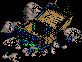

In [63]:
pic_of_all(sunduk10, all_palettes['unpacked/003X.PAL'])

In [64]:
pic_of_all(sunduk10, all_palettes['unpacked/003X.PAL']), pic_of_all(sunduk10, all_palettes['unpacked/003X.PAL'])

(<PIL.Image.Image image mode=RGB size=82x62>,
 <PIL.Image.Image image mode=RGB size=82x62>)

In [67]:
for name, palette in all_palettes.items():
    pic = pic_of_all(sunduk10, palette)
    pic_name = 'picsPalettes/' + name.split('/')[-1] + '.png'
    os.makedirs(os.path.dirname(pic_name), exist_ok=True)
    pic.save(pic_name)

In [67]:
for name, palette in all_palettes.items():
    pic = pic_of_all(sunduk10, palette)
    pic_name = 'picsPalettes/' + name.split('/')[-1] + '.png'
    os.makedirs(os.path.dirname(pic_name), exist_ok=True)
    pic.save(pic_name)

In [68]:
# gp_files = glob.glob("unpacked/*.GP")
# 
# import os
# 
# for gp_file in gp_files:
#     try:
#         header = GpGlobalHeader.parse(read_binary(gp_file))
#         pic = pic_of_all(header, all_palettes['unpacked/AGEW_1.PAL'])
#         pic_name = 'pics_AGEW_1/' + gp_file.split('/')[-1] + '.png'
#         os.makedirs(os.path.dirname(pic_name), exist_ok=True)
#         pic.save(pic_name)
#     except Exception as e:
#         print(f"{e} for {gp_file}")

index out of range for unpacked/MAMG.GP
index out of range for unpacked/KUTDEZ.GP


In [76]:
# gp_files = glob.glob("unpacked/*.GP")
# 
# import os
# 
# for gp_file in gp_files:
#     try:
#         header = GpGlobalHeader.parse(read_binary(gp_file))
#         pics = pics_of_all(header, all_palettes['unpacked/AGEW_1.PAL'])
#         pics = [p for p in pics if p.size != (1, 1)]
# 
#         for i, pic in enumerate(pics):
#             pic_name = 'pics_seq_AGEW_1/' + gp_file.split('/')[-1] + f'/{i:03d}.png'
#             os.makedirs(os.path.dirname(pic_name), exist_ok=True)
#             pic.save(pic_name)
#     except Exception as e:
#         print(f"{e} for {gp_file}")

index out of range for unpacked/MAMG.GP
index out of range for unpacked/KUTDEZ.GP
